In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping

In [ ]:
# Parameters
stocks = 'TSLA'
start_date = '2014-01-01'
end_date = '2024-12-31'
input_days_list = [60, 30, 10, 5]  # Different input days for training

In [ ]:
# Download stock data
df = yf.download(stocks, start=start_date, end=end_date)
df.reset_index(inplace=True)

# Data Preparation
features = df['Close'].values
features = features.astype('float32')

[*********************100%***********************]  1 of 1 completed


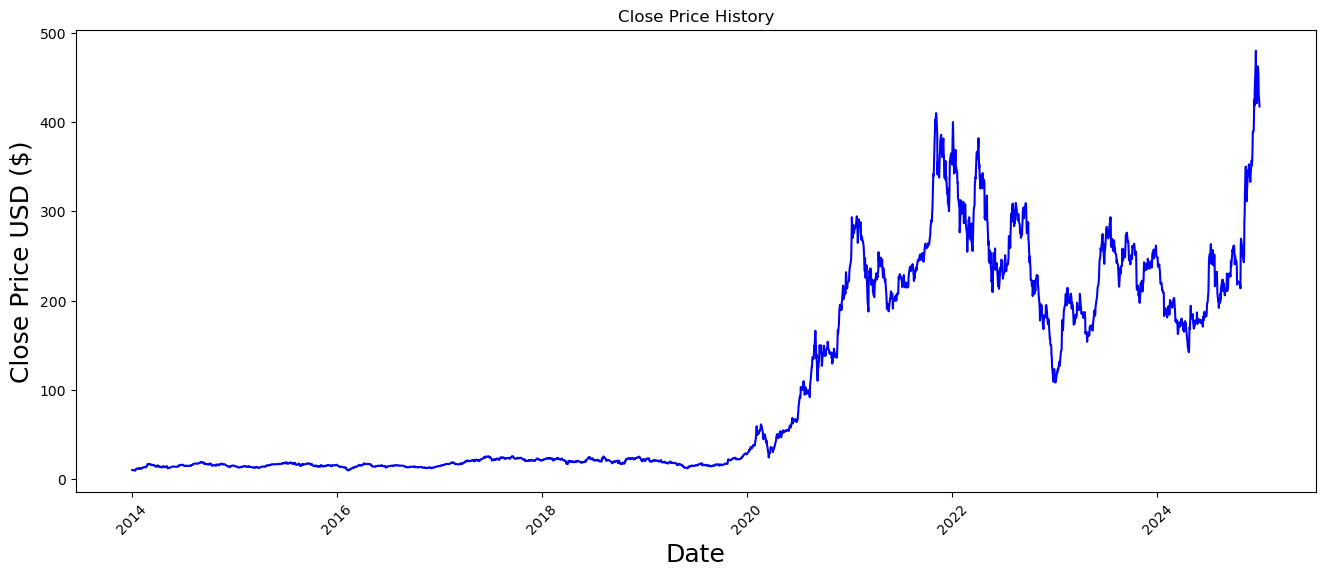

In [ ]:
# Plotting the closing price
plt.figure(figsize=(16, 6))
plt.plot(df['Date'], df['Close'], color='blue')
plt.title('Close Price History')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Normalize the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features.reshape(-1, 1))

# Prepare sequences
training_data_len = int(np.ceil(len(scaled_features) * 0.8))

In [ ]:
# Create a function to train, predict, and visualize with various input days
def train_and_predict(input_days):
    # Create training data
    train_data = scaled_features[:training_data_len]
    x_train, y_train = [], []

    for i in range(input_days, len(train_data)):
        x_train.append(train_data[i-input_days:i])
        y_train.append(train_data[i])

    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Reshape x_train for LSTM
    x_train = x_train.reshape(-1, input_days, 1)

    # Create testing data
    test_data = scaled_features[training_data_len - input_days:]
    x_test, y_test = [], []

    for i in range(input_days, len(test_data)):
        x_test.append(test_data[i-input_days:i])
        y_test.append(test_data[i])

    x_test = np.array(x_test)
    y_test = np.array(y_test)

    # Reshape x_test for LSTM
    x_test = x_test.reshape(-1, input_days, 1)

    # Initialize and compile the model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Fit the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=1, shuffle=False)

    # Make predictions
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)

    # Inverse transform the predictions to get the actual prices
    train_predictions = scaler.inverse_transform(train_predictions)
    test_predictions = scaler.inverse_transform(test_predictions)

    # Visualization of Predictions
    train = df[:training_data_len]
    valid = df[training_data_len:].copy()
    valid['Predictions'] = test_predictions.flatten()

    plt.figure(figsize=(16, 6))
    plt.title(f'LSTM Model Predictions with {input_days} Days Input')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)
    plt.plot(train['Date'], train['Close'], label='Train')
    plt.plot(valid['Date'], valid['Close'], label='Val', color='green')
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions', color='orange')
    plt.legend(loc='lower right')
    plt.show()

    # Calculate performance metrics
    mse = mean_squared_error(valid['Close'], valid['Predictions'])
    mae = mean_absolute_error(valid['Close'], valid['Predictions'])
    rmse = np.sqrt(mse)
    r2 = r2_score(valid['Close'], valid['Predictions'])

    print(f"Performance metrics for input days {input_days}:")
    print(f"R² Score: {r2:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("\n")

    # Plot train and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss', color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
    plt.title(f'Model Train vs Validation Loss with {input_days} Days Input')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

    # Predict the next day using the last input_days
    last_input_days = scaled_features[-input_days:]
    last_input_days = last_input_days.reshape((1, input_days, 1))

    predicted_price = model.predict(last_input_days)
    predicted_price = scaler.inverse_transform(predicted_price)

    # Display the next day's predicted price
    next_day_date = df['Date'].iloc[-1] + pd.Timedelta(days=1)
    predicted_df = pd.DataFrame(data=predicted_price, index=[next_day_date], columns=['Predicted Close'])

    print(f"Predicted stock price for {next_day_date.date()} (using last {input_days} days): ${predicted_price[0][0]:.2f}")

    # Plotting the results
    plt.figure(figsize=(10, 5))
    plt.plot(df['Date'], df['Close'], label='Historical Close Prices', color='blue')
    plt.axvline(x=next_day_date, color='orange', linestyle='--', label='Prediction Date')
    plt.scatter(next_day_date, predicted_price, color='red', label='Predicted Price', s=100)

    # Add titles and labels
    plt.title('Predicted Next Day Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Price in USD')
    plt.legend()
    plt.grid()
    plt.show()

Epoch 1/50


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 5.3370e-04 - val_loss: 0.0077
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0070 - val_loss: 0.0042
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0081 - val_loss: 0.0055
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0125 - val_loss: 0.0049
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0127 - val_loss: 0.0042
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0086 - val_loss: 0.0039
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0054 - val_loss: 0.0044
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0049 - val_loss: 0.0050
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0058 - val_loss: 0.0052
Epoch 10/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0064 - val_loss: 0.0049
Epoch 11/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0069 - val_loss: 0.0056
Epoch 12/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0072 - v

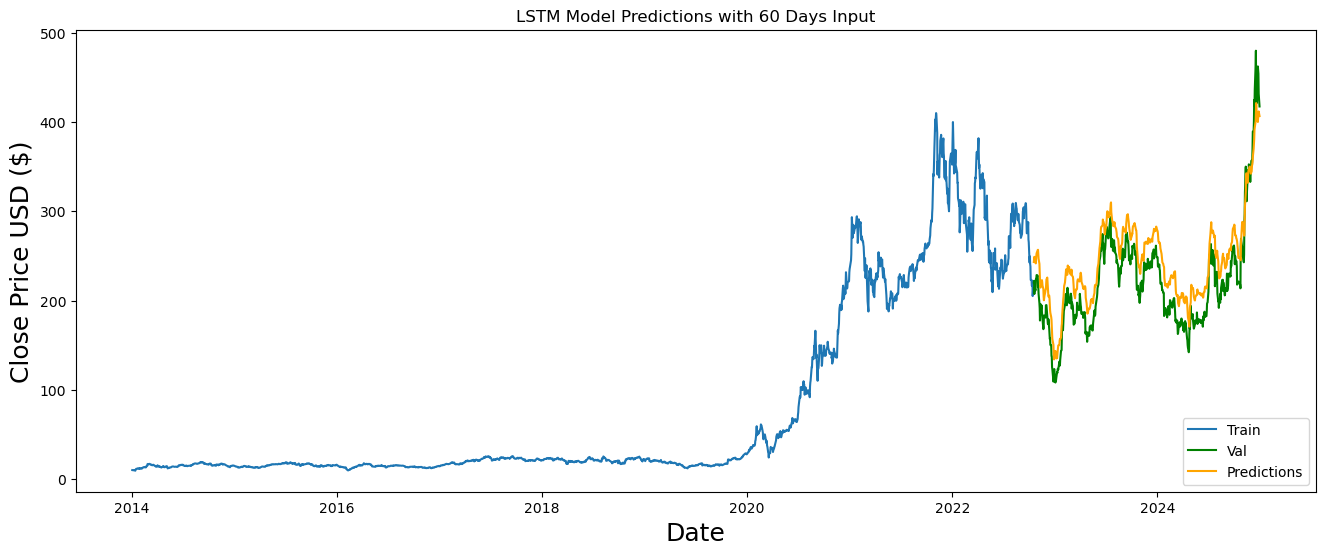

Performance metrics for input days 60:
R² Score: 0.7428
Mean Absolute Error (MAE): 27.6385
Mean Squared Error (MSE): 851.0045
Root Mean Squared Error (RMSE): 29.1720




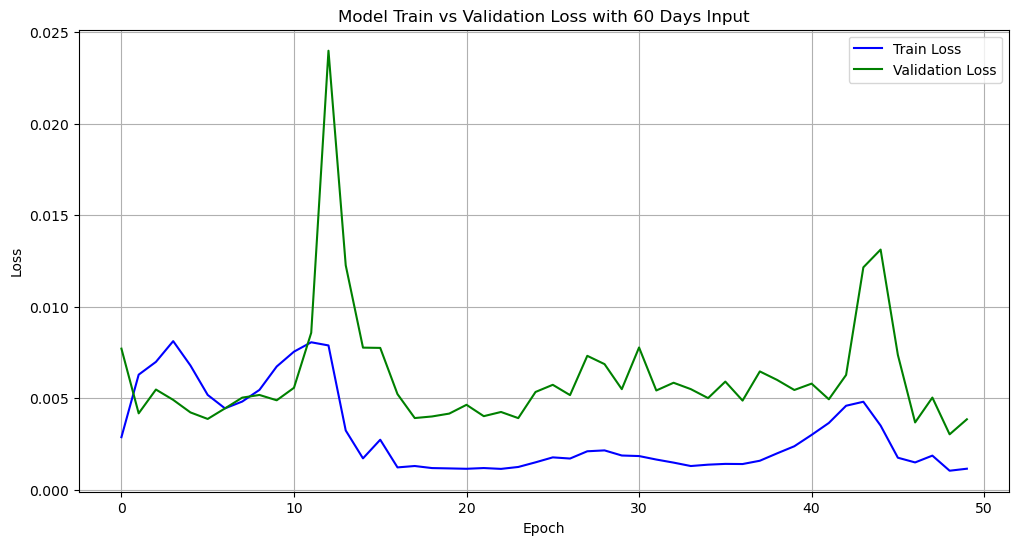

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Predicted stock price for 2024-12-31 (using last 60 days): $399.24


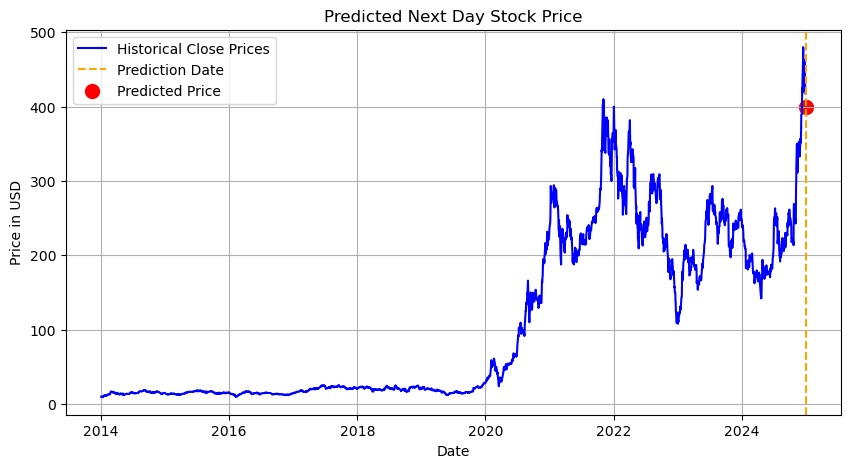

Epoch 1/50


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 4.8795e-04 - val_loss: 0.0069
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0095 - val_loss: 0.0044
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0087 - val_loss: 0.0052
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0124 - val_loss: 0.0060
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0093 - val_loss: 0.0061
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0084 - val_loss: 0.0063
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0060 - val_loss: 0.0051
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0052 - val_loss: 0.0071
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0050 - val_loss: 0.0138
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0038 - val_loss: 0.0213
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 9.9729e-04

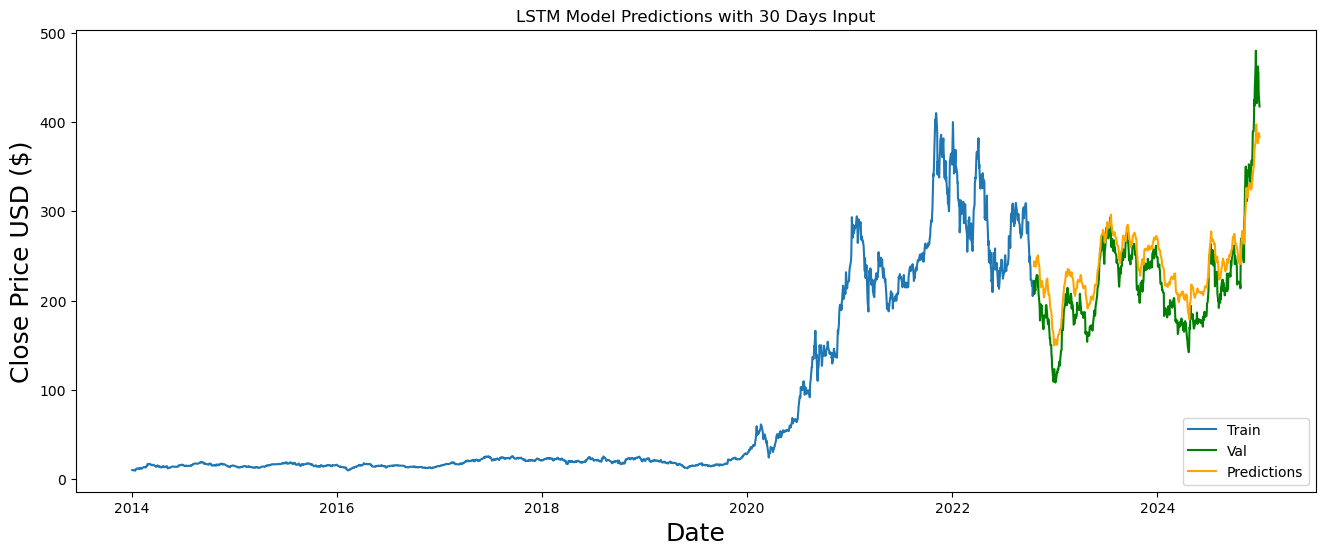

Performance metrics for input days 30:
R² Score: 0.7510
Mean Absolute Error (MAE): 26.0889
Mean Squared Error (MSE): 823.9134
Root Mean Squared Error (RMSE): 28.7039




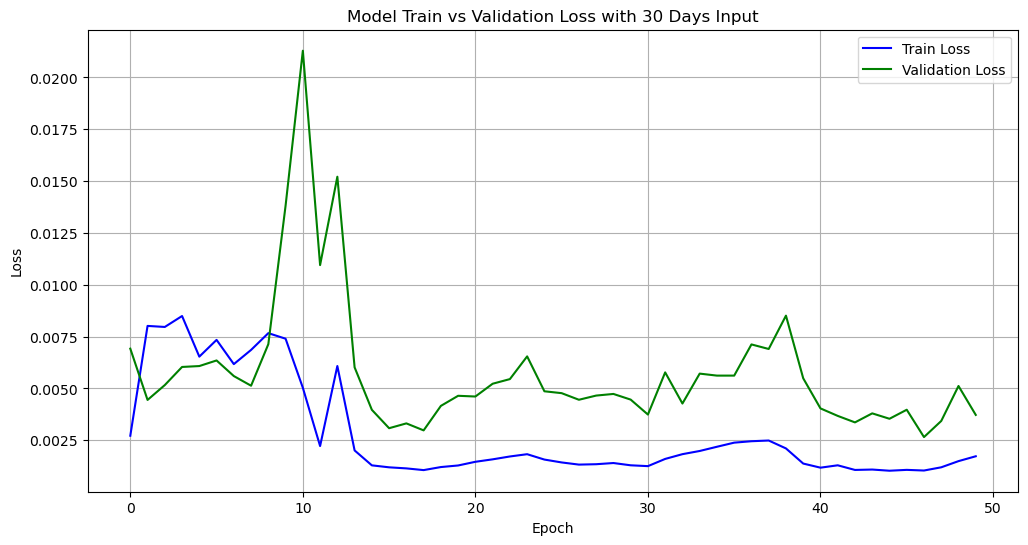

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted stock price for 2024-12-31 (using last 30 days): $376.21


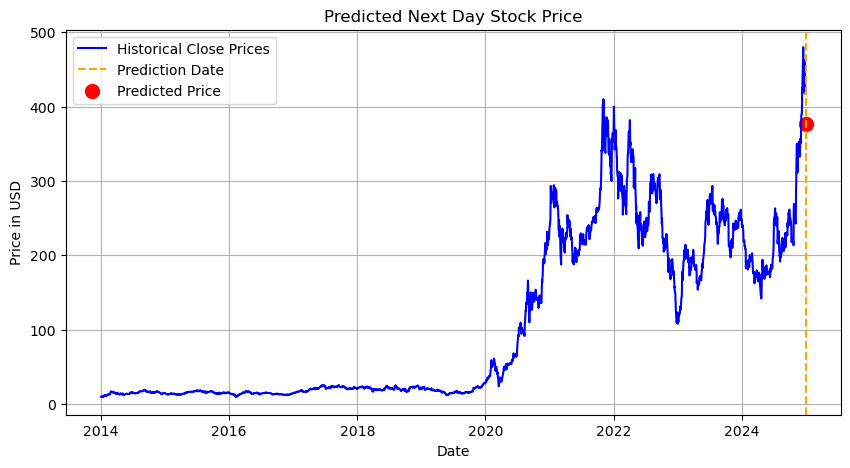

Epoch 1/50


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 3.8793e-04 - val_loss: 0.0062
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - val_loss: 0.0051
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0119 - val_loss: 0.0076
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0098 - val_loss: 0.0064
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0089 - val_loss: 0.0060
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - val_loss: 0.0068
Epoch 7/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0099 - val_loss: 0.0124
Epoch 8/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0087 - val_loss: 0.0343
Epoch 9/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0041 - val_loss: 0.0109
Epoch 10/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 11/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0016 - val_loss: 0.0049
Epoch 12/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.3677e-04 - val_loss

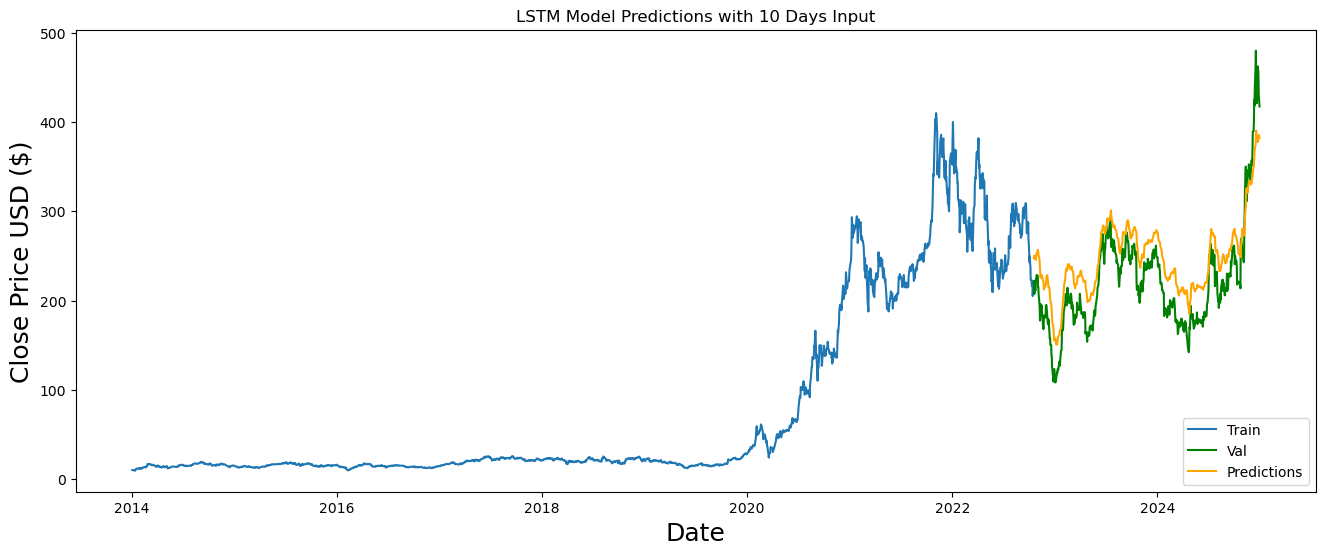

Performance metrics for input days 10:
R² Score: 0.6488
Mean Absolute Error (MAE): 31.7359
Mean Squared Error (MSE): 1162.1004
Root Mean Squared Error (RMSE): 34.0896




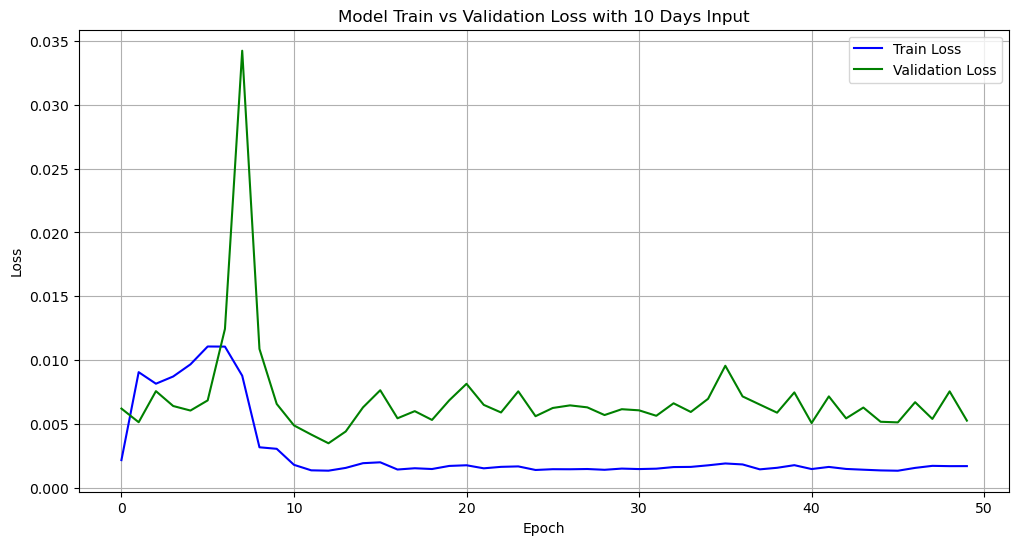

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted stock price for 2024-12-31 (using last 10 days): $377.24


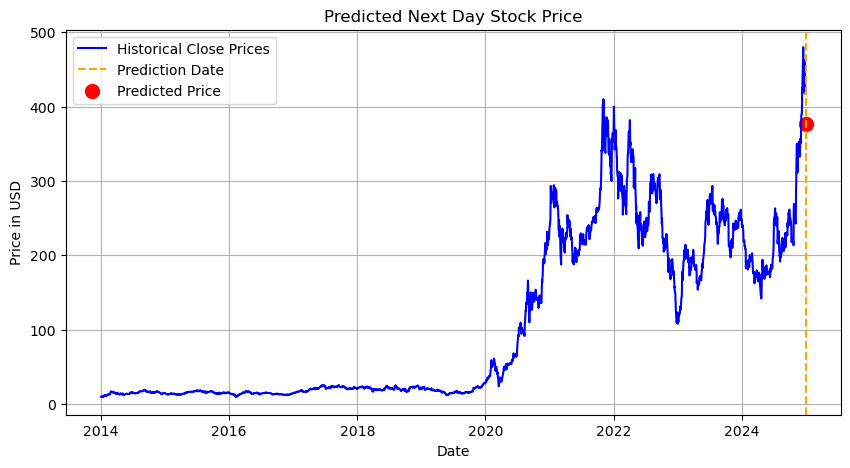

Epoch 1/50


c:\Users\ben\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 8.6812e-04 - val_loss: 0.0059
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0162 - val_loss: 0.0070
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0226 - val_loss: 0.0179
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0291 - val_loss: 0.0510
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317 - val_loss: 0.0046
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0069 - val_loss: 0.0024
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 10/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0013 - val_loss: 0.0028
Epoch 11/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 12/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.

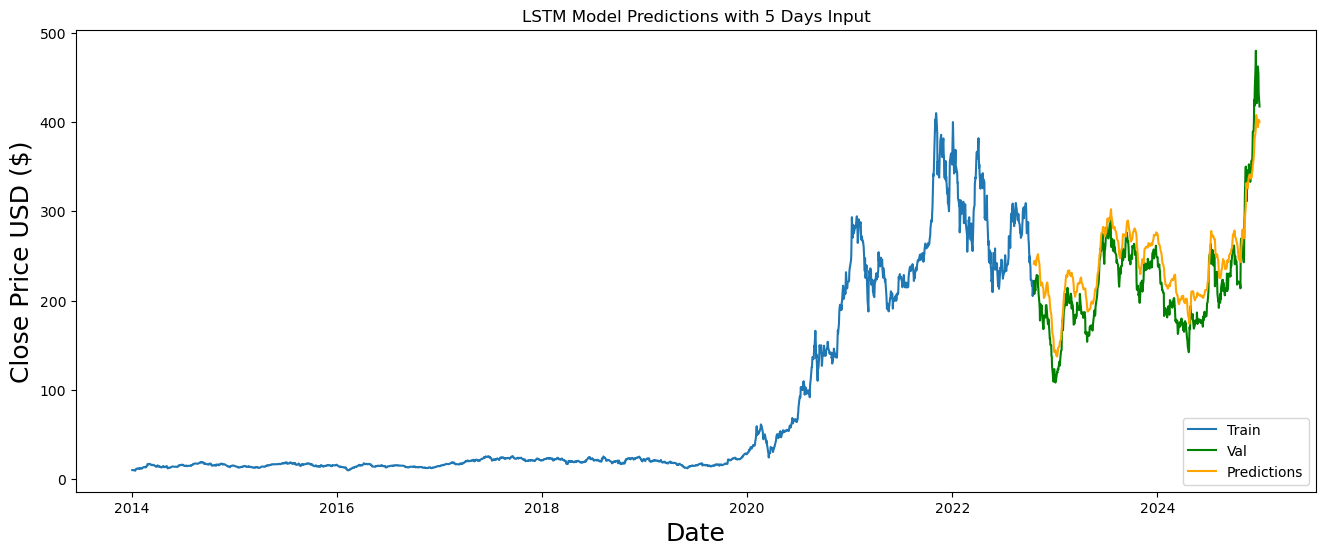

Performance metrics for input days 5:
R² Score: 0.7722
Mean Absolute Error (MAE): 25.3057
Mean Squared Error (MSE): 753.5819
Root Mean Squared Error (RMSE): 27.4514




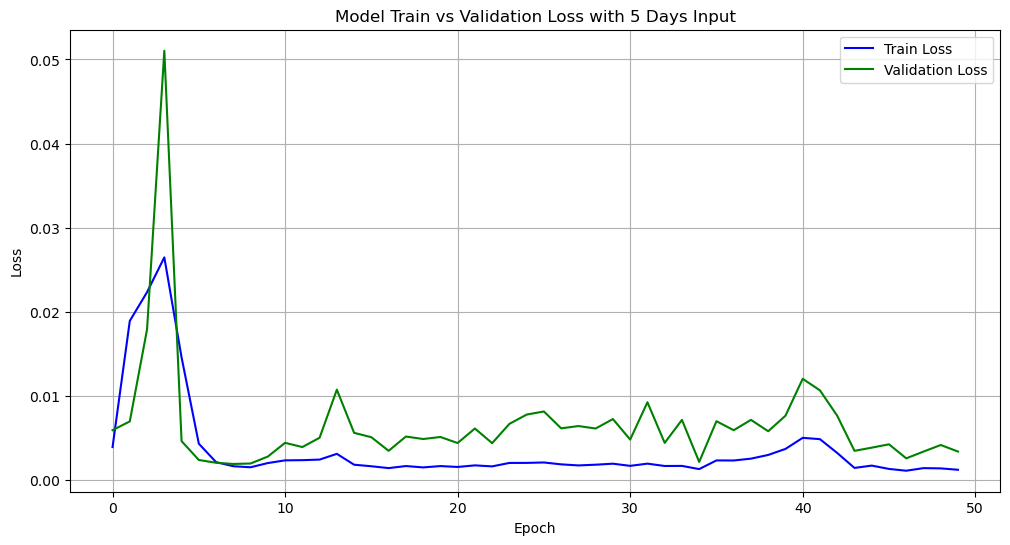

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted stock price for 2024-12-31 (using last 5 days): $395.02


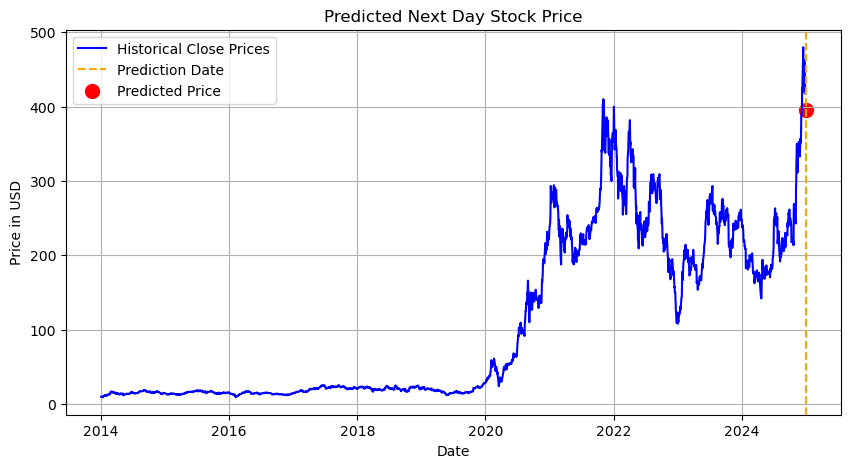

In [ ]:
# Loop through different input lengths
for input_days in input_days_list:
    train_and_predict(input_days)